# Certificate Characteristics

#### Determining maliciousness from web certificates proved very useful with other intern models reaching 88% accuracy.  While those schemes were based on the presence or absence of data, this document strived to pull more information from the original feature set.  Unfortunately, this didn't yield impressive results and was actually less effective than the more rudimentary techniques

#### ** Look for places to load in serialized data as it will save a significant amount of time

### Parse Data

In [1]:
import json
import time
import random
import re
import os
import pickle
import datetime
import operator

import numpy as np
import pandas as pd
from pprint import pprint
from collections import defaultdict
from scipy.stats import chisquare
import multiprocessing as mp
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import chi2

#### Create dataframe from scratch

In [ ]:
## Enumerate all files with pertinent data
everyFile=[]
tmp=os.listdir('/data/data/')
tmp.remove('newbenigndata')
for x in tmp:
    try:
        folder='/data/data/'+x+'/enrichment/cert_info/'
        for y in os.listdir(folder):
            if (len(y) > 15):
                everyFile.append(folder+y)
    except:
        continue
        
print(len(everyFile))
        
for x in os.listdir('/data/data/newNONTORbenigndata/enrichment/cert_info/'):
        everyFile.append('/data/data/newNONTORbenigndata/enrichment/cert_info/'+x)

print(len(everyFile))

#### Update existing dataframe with a new files

In [ ]:
everyFile=[]
tmp=os.listdir('/data/data/')
for x in tmp[-10:-3]:
    try:
        folder='/data/data/'+x+'/enrichment/cert_info/'
        for y in os.listdir(folder):
            everyFile.append(folder+y)
    except:
        continue

#### Iterate over files to parse data

In [ ]:
df_cols=['benign', 'indicator', 'error_type', 'cert_validation', 'success', 
         'authorityInfoAccess', 'basicConstraints', 'certificatePolicies',
         'has_expired', 'notAfter', 'notBefore']

col_check=set(df_cols)
error_types=defaultdict(int)
validation_types=defaultdict(int)
usage_types=defaultdict(int)
issuers=defaultdict(int)
ctr=0
lamow=[]
for x in everyFile:
    ctr+=1
    if (ctr % 170 == 0):
        print(ctr/340,'%')
    try:
        book=json.load(open(x))['data']
        for cert_dict in book:
            df=pd.DataFrame(columns=df_cols)
            df['benign']=[len(x)-x.rfind('/')<15]
            infoString=None  
            if (cert_dict.get('cert_info') == None):
                infoString='certificate_info'
            else:
                infoString='cert_info'
                
            if (type(cert_dict[infoString]) != dict):
                df['indicator']=[cert_dict['indicator']]
                df['success']=[cert_dict['success']]
                #try:
                    #df['error_type']=re.findall("\[.*\]",cert_dict[infoString])[0]
                #except Exception as s:
                df['error_type']=[cert_dict[infoString]]
                
                error_types[df['error_type'][0]]+=1

            else:
                df['indicator']=[cert_dict['indicator']]
                df['success']=[cert_dict['success']]
                df['cert_validation'] = [cert_dict.get('cert_validation')]
                
                #try:
                    #validation_types[re.findall("\[.*\]",cert_dict.get('cert_validation'))[0]]+=1
                #except:
                validation_types[df['cert_validation'][0]]+=1
                    
                if (cert_dict[infoString].get('subject') != None):
                    alpha=cert_dict[infoString]['subject'].get('CN',' ')+cert_dict[infoString].get('subjectAltName','')
                    df['subject_len']=len(cert_dict[infoString]['subject'])
                    df['subject_match'] = [alpha.find(cert_dict['indicator']) != -1]
                    df['alt_subjects'] = [alpha.count(',')]
                    
                df['issuer']=cert_dict[infoString].get('issuer',{}).get('CN')
                df['issuer_len']=len(cert_dict[infoString].get('issuer',{}))
                issuers[df['issuer'][0] or '']+=1
                df['keyUsage']=[cert_dict[infoString].get('keyUsage','').split(',')]
                df['extendedKeyUsage']=[cert_dict[infoString].get('extendedKeyUsage','').split(',')]
                for yy in df['keyUsage'][0]:
                    usage_types[yy]+=1
                
                for q in cert_dict[infoString]:
                    if (q in col_check):
                        df[q]=[cert_dict[infoString][q]]
                        
            lamow.append(df)
    except Exception as e:
        #print(e)
        continue
        

In [ ]:
df=pd.concat(lamow,axis=0)
del lamow
def convertToDt(date_string):
    try:
        if (type(date_string) != float):
            return datetime.datetime.strptime(date_string,'%Y/%m/%d %H:%M.%S')
        else:
            return None
    except Exception as e:
        print(date_string)
        print(e)
        
df['notAfter']=df['notAfter'].apply(convertToDt)
df['notBefore']=df['notBefore'].apply(convertToDt)
df.reset_index(drop=True,inplace=True)

In [ ]:
## Many duplicate entries due to errors in collection script

df=df.drop_duplicates(subset=df.columns.difference(['keyUsage','extendedKeyUsage']))
df.reset_index(drop=True,inplace=True)

## Load saved dataframe

In [2]:
df=pd.concat([pickle.load(open('cert_info_full1.pickle','rb')),pickle.load(open('cert_info_full2.pickle','rb')),
              pickle.load(open('cert_info_full3.pickle','rb'))],axis=0)

df=df.drop_duplicates(subset=df.columns.difference(['keyUsage','extendedKeyUsage']))
df.reset_index(drop=True,inplace=True)

In [ ]:
# Ignore this one

df=pickle.load(open('cert_info.pickle','rb'))
df_temp=pickle.load(open('cert_info_newbenign.pickle','rb'))
df_temp['benign']=True
df=pd.concat([df,df_temp],axis=0)

df=df.drop_duplicates(subset=df.columns.difference(['keyUsage','extendedKeyUsage']))
df.reset_index(drop=True,inplace=True)

In [3]:
df=df[df.error_type.apply(lambda x: type(x) == float)]
df['benign'].value_counts()

True     853917
False     64286
Name: benign, dtype: int64

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


N = 2
menMeans = (146008,369053)
womenMeans = (853917,64286)
ind = [0,0.25]    # the x locations for the groups
width = 0.15       # the width of the bars: can also be len(x) sequence

plt.figure(figsize=(14,8))
p1 = plt.bar(ind, menMeans, width,color='salmon')
p2 = plt.bar(ind, womenMeans, width,
             bottom=menMeans,color='palegreen')

plt.ylabel('Domains',fontsize=24)
plt.title('Certificate Posession',fontsize=24,pad=12)
plt.xticks(ind, ('Benign', 'Malicious'),fontsize=24)
plt.yticks(np.arange(0, 1100000, 200000))
plt.legend((p1[0], p2[0]), ('No Certificate', 'Some Certificate'),fontsize=12)

plt.show()

In [ ]:
len(df[df['benign'] == False]['error_type'])

In [ ]:
sum(df[df['benign'] == False]['error_type'].isna())

## Augment Features

In [ ]:
usage_types=pickle.load(open('usage_types.pickle','rb'))
usage_types={x.strip() for x in usage_types.keys()}

#### Add one-hot encodings for issuers and usage types

In [ ]:
for x in usage_types:
    df.insert(loc=16,column=x,value=np.zeros(shape=[len(df)],dtype=bool))
    
df.drop(columns='',inplace=True)
df.reset_index(drop=True,inplace=True)

In [ ]:
for x in sorted_all:
    df.insert(loc=23,column=x,value=np.zeros(shape=[len(df)],dtype=bool))
    
df.insert(loc=35,column='valid_duration',value=np.zeros(shape=[len(df)]))

for x in error_codes:
    df.insert(loc=35,column=x,value=np.zeros(shape=[len(df)],dtype=bool))

In [ ]:
#for i in range(0, len(df)):
#    if (type(df.loc[i,'keyUsage']) == list):
#        for x in df.loc[i,'keyUsage']:
#            df.loc[i,x.strip()]=True
df

In [ ]:
def oneHotUsageIssue(row):
    global df
    if (type(df.loc[row,'keyUsage']) == list):
        for x in df.loc[row,'keyUsage']:
            df.loc[row,x.strip()]=True
            
    if (not pd.isnull(df.loc[row,'issuer'])):
        issr=df.loc[row,'issuer']
        if issr[0:issr.find(' ')] in sorted_all:
            df.loc[row,issr[0:issr.find(' ')]]=True
            
    if (not pd.isnull(df.loc[row,'notBefore']) and type(df.loc[row,'notAfter']) != float):
        try:
            df.loc[row,'valid_duration']=(df.loc[row,'notAfter']-df.loc[row,'notBefore']).days
        except Exception as e:
            print(e)
            
    if (type(df.loc[row,'cert_validation']) == str):
        if (df.loc[row,'cert_validation'] in error_codes):
            df.loc[row,df.loc[row,'cert_validation']]=True
            
    return df.loc[row]

results=[]
pool = mp.Pool(mp.cpu_count()*2)
results = pool.map_async(oneHotUsageIssue, [x for x in range(0,len(df))])
pool.close()

#### Save augmented feature dataframe

In [ ]:
while(True):
    try:
        df=pd.DataFrame(results.get(0))
        break
    except:
        continue
        
with open('thistookallday.pickle','wb') as output:
    pickle.dump(df,output,pickle.HIGHEST_PROTOCOL)

### Load Augmented feature dataframe

In [10]:
df=pickle.load(open('thistookallday.pickle','rb'))
df=df[df.error_type.apply(lambda x: type(x) == float)]
df['benign'].value_counts()

True     853917
False     64286
Name: benign, dtype: int64

In [ ]:
#temp_df=pd.DataFrame(np.zeros(shape=[len(df),1]),columns=['valid_duration'])

In [ ]:
#for i in range(0, len(df)):
 #   if (not pd.isnull(df.loc[i,'notBefore']) and type(df.loc[i,'notAfter']) != float):
  #      try:
   #         temp_df.loc[i,'valid_duration']=(df.loc[i,'notAfter']-df.loc[i,'notBefore']).days
    #    except:
     #       continue

#df=pd.concat([df,temp_df],axis=1)

In [ ]:
df[df.columns.difference(['authorityInfoAccess','basicConstraints','indicator',
                          'notAfter','notBefore','certificatePolicies','error_type','extendedKeyUsage',
                         'issuer','keyUsage','cert_validation',''])]

#### Clean dataframe

In [11]:
def replaceTFNan(val):
    if (pd.isnull(val)):
        return 0
    elif (val == False):
        return 1
    else:
        return 2
          

df['has_expired']=df['has_expired'].apply(replaceTFNan)
df['subject_match']=df['subject_match'].apply(replaceTFNan)

def replaceCertVal(val):
    if (pd.isnull(val)):
        return 0
    elif (val == True):
        return 1
    elif (type(val) == str):
        return 2

df['cert_validation']=df['cert_validation'].apply(replaceCertVal)

In [ ]:
#general_issuers=list(general_issuers.keys())

#def replaceIssuer(val):
#    if (type(val) == float):
#        return None
#    elif (type(val) == str):
#        try:
#            return general_issuers.index(val)
#        except:
#            return len(general_issuers)

#df['issuer']=df['issuer'].apply(replaceIssuer)

In [ ]:
general_issuers=defaultdict(int)

for x in issuers:
    if issuers[x] != 1:
        general_issuers[x.split(' ')[0]]+= issuers[x]
        
pprint(general_issuers)

In [ ]:
#with open('cert_info_full_all.pickle', 'wb') as output:  # Overwrites any existing file.
#    pickle.dump(df, output, pickle.HIGHEST_PROTOCOL)

In [ ]:
#with open('error_types.pickle', 'wb') as output:  # Overwrites any existing file.
#    pickle.dump(error_types, output, pickle.HIGHEST_PROTOCOL)
    
#with open('validation_types.pickle', 'wb') as output:  # Overwrites any existing file.
#    pickle.dump(validation_types, output, pickle.HIGHEST_PROTOCOL)
    
#with open('usage_types.pickle', 'wb') as output:  # Overwrites any existing file.
#    pickle.dump(usage_types, output, pickle.HIGHEST_PROTOCOL)

# Compare classifiers

In [ ]:
df.columns

In [ ]:
ad=df[df.columns.difference(['authorityInfoAccess','basicConstraints','indicator',
                          'notAfter','notBefore','certificatePolicies','error_type','extendedKeyUsage',
                         'issuer','keyUsage',''])][df.error_type.apply(lambda x: type(x) == float)]

In [4]:
ad=df[df.columns.difference(['authorityInfoAccess','basicConstraints','indicator',
                          'notAfter','notBefore','certificatePolicies','error_type','extendedKeyUsage',
                         'issuer','keyUsage',''])][df.error_type.apply(lambda x: type(x) == float)]
bd=ad[ad.benign == True]
md=ad[ad.benign == False]
bd=bd.sample(frac=1).reset_index(drop=True)
bd=bd[0:len(md)]
ad=pd.concat([md,bd], axis = 0)
ad=ad.sample(frac=1).reset_index(drop=True)

In [5]:
X_t, X_v, y_t, y_v = train_test_split(ad.drop(columns=['benign']).fillna(0),ad['benign'],test_size=.25)

In [ ]:
X_v.columns

In [ ]:
for x in X_t.columns:
    print(X_t[x].value_counts())

In [ ]:
y_t.value_counts()

In [16]:
rdf = RandomForestClassifier(n_estimators=200,random_state=23874).fit(X_t,y_t)
lgr= LogisticRegression(solver='liblinear', multi_class='ovr',random_state=87348).fit(X_t,y_t)
mlp = MLPClassifier(alpha=1e-5, hidden_layer_sizes=(64,64,64),max_iter=100,verbose=1, n_iter_no_change=10,
                    shuffle=True,learning_rate_init=.0001,solver='adam',batch_size=256).fit(X_t,y_t)

Iteration 1, loss = inf
Iteration 2, loss = inf
Iteration 3, loss = inf
Iteration 4, loss = inf
Iteration 5, loss = inf
Iteration 6, loss = inf
Iteration 7, loss = inf
Iteration 8, loss = inf
Iteration 9, loss = inf
Iteration 10, loss = inf
Iteration 11, loss = inf
Iteration 12, loss = inf
Iteration 13, loss = inf
Iteration 14, loss = inf
Iteration 15, loss = inf
Iteration 16, loss = inf
Iteration 17, loss = inf
Iteration 18, loss = inf
Iteration 19, loss = inf
Iteration 20, loss = inf
Iteration 21, loss = inf
Iteration 22, loss = inf
Iteration 23, loss = inf
Iteration 24, loss = inf
Iteration 25, loss = inf
Iteration 26, loss = inf
Iteration 27, loss = inf
Iteration 28, loss = inf
Iteration 29, loss = inf
Iteration 30, loss = inf
Iteration 31, loss = inf
Iteration 32, loss = inf
Iteration 33, loss = inf
Iteration 34, loss = inf
Iteration 35, loss = inf
Iteration 36, loss = inf
Iteration 37, loss = inf
Iteration 38, loss = inf
Iteration 39, loss = inf
Iteration 40, loss = inf
Iteration

/home/ubuntu/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [17]:
print(rdf.score(X_v,y_v))
print(lgr.score(X_v,y_v))
print(mlp.score(X_v,y_v))

0.8289518713250164
0.7892542699810223
0.7120679463646828


In [ ]:
rdf.predict_proba(X_v)[:,0]

In [18]:
print("Classification report for classifier %s:\n%s\n"
      % (rdf, classification_report(y_v, rdf.predict(X_v))))
print("Confusion matrix:\n%s" % confusion_matrix(y_v, rdf.predict(X_v)))

print("Classification report for classifier %s:\n%s\n"
      % (lgr, classification_report(y_v, lgr.predict(X_v))))
print("Confusion matrix:\n%s" % confusion_matrix(y_v, lgr.predict(X_v)))

print("Classification report for classifier %s:\n%s\n"
      % (mlp, classification_report(y_v, mlp.predict(X_v))))
print("Confusion matrix:\n%s" % confusion_matrix(y_v, mlp.predict(X_v)))

Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=23874,
                       verbose=0, warm_start=False):
              precision    recall  f1-score   support

       False       0.90      0.75      0.81     16194
        True       0.78      0.91      0.84     15949

    accuracy                           0.83     32143
   macro avg       0.84      0.83      0.83     32143
weighted avg       0.84      0.83      0.83     32143


Confusion matrix:
[[12095  4099]
 [ 1399 14550]]
Classification report for classifier LogisticRegression(C=1.0, class_weight=None, dual=False,

In [15]:
importances=dict(zip(rdf.feature_importances_, X_t.columns))
pprint(importances)

{0.0: 'CERT MISMATCH',
 1.8566818471537782e-07: 'Decipher Only',
 2.0157913485360133e-07: 'Encipher Only',
 0.00010846061108657436: 'CRL Sign',
 0.00022968696422561217: 'success',
 0.00045845473462153544: 'Certificate Sign',
 0.0005607827730890928: 'Key Agreement',
 0.0006746575396403915: 'Data Encipherment',
 0.0009679524853115412: 'Amazo',
 0.0017574303407336333: 'Go',
 0.001810738523826255: 'GlobalSign',
 0.001955673448499932: '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify '
                       'failed: certificate has expired (_ssl.c:1056)',
 0.0022595556868647646: '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify '
                        'failed: self signed certificate in certificate chain '
                        '(_ssl.c:1056)',
 0.0025139610005343797: 'Non Repudiation',
 0.002688891334586264: 'Sectigo',
 0.002824296046592209: 'RapidSSL',
 0.004018847662269437: 'CloudFlare',
 0.004285934791284155: 'DigiCert',
 0.005174653797603243: '_ssl.c:1039: The handshake oper

### Examine certificate issuers and error types

In [3]:
issuer_benign=pickle.load(open('issuer_benign.pickle','rb'))
issuer_mal=pickle.load(open('issuer_mal.pickle','rb'))

In [4]:
sorted_benign = sorted(issuer_benign.items(), key=operator.itemgetter(1),reverse=True)
sorted_mal = sorted(issuer_mal.items(), key=operator.itemgetter(1),reverse=True)

In [5]:
temp_all={}
for x in issuer_benign:
    temp_all[x]=issuer_benign[x]+issuer_mal[x]
    
issuer_all=defaultdict(int)
for x in temp_all:
    try:
        issuer_all[x[0:x.find(' ')]]+=temp_all[x]
    except:
        print(x)
        
del temp_all

None


In [8]:
#Sort issuers by frequency

sorted_all = sorted(issuer_all.items(), key=operator.itemgetter(1),reverse=True)

#Select top 10 issuers
sorted_all= [x[0] for x in sorted_all[0:10]]

In [9]:
# Translate top issuers into a set

sorted_all={x for x in sorted_all}
sorted_all

{'Amazo',
 'COMODO',
 'CloudFlare',
 'DigiCert',
 'GlobalSign',
 'Go',
 "Let's",
 'RapidSSL',
 'Sectigo',
 'cPanel,'}

In [10]:
# Inspect error types

validation_types=pickle.load(open('validation_types.pickle','rb'))
error_types=pickle.load(open('error_types.pickle','rb'))

In [18]:
# This is kind of a meaningless dictionary

better_val_types=defaultdict(int)
for x in validation_types:
    try:
        better_val_types[x[0:x.find(',')]]+=1
    except:
        continue
        
pprint(better_val_types)

defaultdict(<class 'int'>,
            {'EOF occurred in violation of protocol (_ssl.c:1056': 1,
             '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: EE certificate key too weak (_ssl.c:1056': 1,
             '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch': 7762,
             '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: IP address mismatch': 9750,
             '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1056': 1,
             '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self signed certificate (_ssl.c:1056': 1,
             '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self signed certificate in certificate chain (_ssl.c:1056': 1,
             '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1056': 1,
             '[SSL: PRE_MAC_LENGTH_TOO_LONG] invalid alert (_ssl.c:1056': 1,
    

In [4]:
df=df.reset_index(drop=True)
for x in range(0,len(df)):
    if type(df.loc[x,'error_type']) == str:
        if df.loc[x,'error_type'].find('[SSL: CERTIFICATE_VERIFY_FAILED]') != -1:
            print(x)
            break

In [5]:
alpha=df['cert_validation'].apply((lambda x: 'CERT MISMATCH' if type(x)==str and x.find('mismatch') != -1 else x)).value_counts()
alpha=alpha[alpha>100]

In [6]:
alpha=set(alpha.index)
alpha.discard(True)

In [7]:
# Error codes set to use for one-hot encoding

error_codes=alpha
error_codes

{'CERT MISMATCH',
 '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1056)',
 '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self signed certificate (_ssl.c:1056)',
 '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self signed certificate in certificate chain (_ssl.c:1056)',
 '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1056)',
 '_ssl.c:1039: The handshake operation timed out'}

In [24]:
#Change issuer to a small portion of the original string for matching

df['issuer']=df['issuer'].apply(lambda x: x[0:x.find(' ')] if (not pd.isnull(x)) else None)

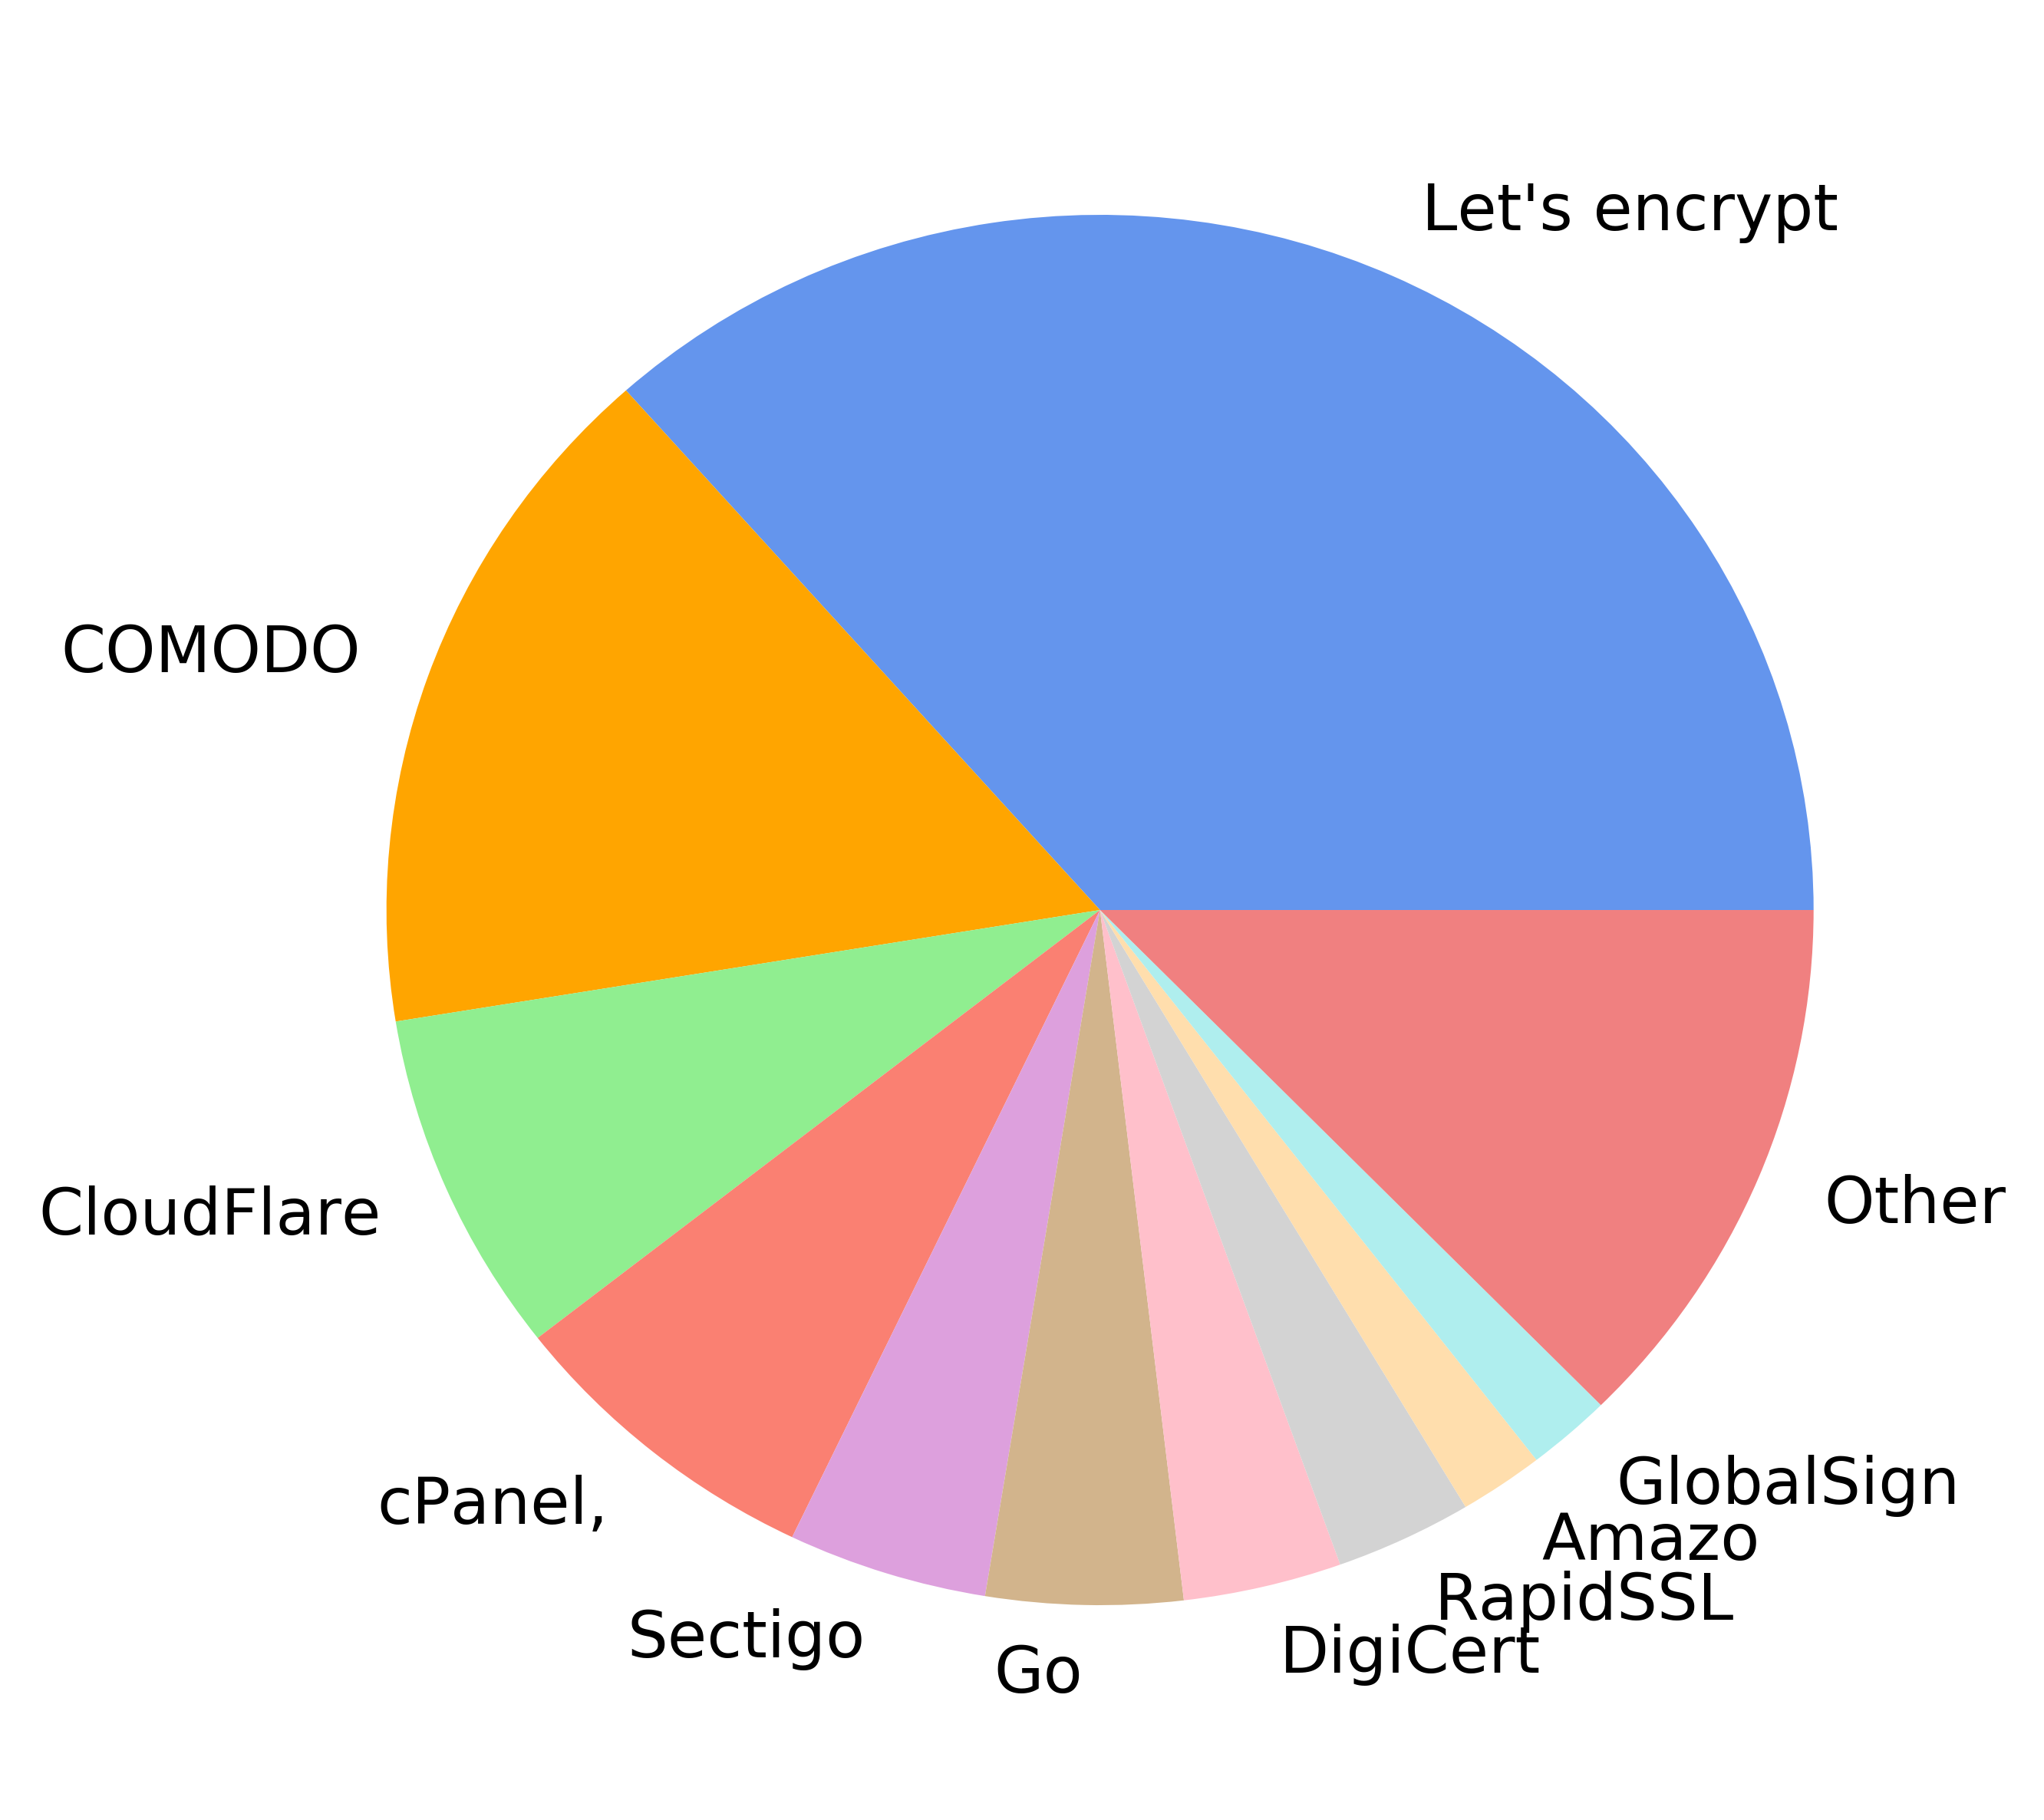

In [41]:
plt.figure(figsize=(6,6),dpi=500)
plt.pie(list(df['issuer'].value_counts()[0:10])+[105818],
        labels=list(["Let's encrypt"]+list(df['issuer'].value_counts()[1:10].index)+["Other"]),
       colors=['cornflowerblue','orange','lightgreen','salmon','plum','tan','pink','lightgray','navajowhite','paleturquoise','lightcoral'],
       textprops=dict(fontsize=12),labeldistance=1.1)
plt.show()

In [ ]:
df[(df['benign'] == True) &(df['valid_duration'] > 0) & (df['valid_duration'] < 1000)]['valid_duration'].hist(bins=50)

In [ ]:
df.corr()